In [1]:
import tensorflow as tf 
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 
from keras.utils.vis_utils import plot_model 

from gensim.models.fasttext import FastText 

import pandas as pd
import numpy as np
import seaborn as sns
import re 
import matplotlib.pyplot as plt 
from numpy import array, asarray, zeros

from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score  

# Load Data Train and Test 

In [2]:
df = pd.read_csv("data_worthcheck/train.csv") 
df.head() 

,Unnamed: 0,text_a,label
0,0,betewe buka twitter cuman ngetweet liat home b...,no
1,1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,2,e100ss gini buka informasi sejelas nya identit...,yes
3,3,neng solo wes ono terduga corona cobo neng ati...,no
4,4,midiahn nii akun gak takut takut nya isu coron...,no


In [3]:
test = pd.read_csv("data_worthcheck/test.csv") 
test['label'] = test['label'].map( {'yes': 1, 'no': 0} ).astype(int) 

# Preprocessing

## Data Understanding

<AxesSubplot:xlabel='label', ylabel='count'>

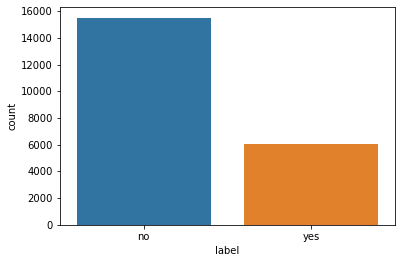

In [4]:
sns.countplot(x='label', data=df) 

In [5]:
df.shape

(21601, 3)

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21601 entries, 0 to 21600
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21601 non-null  int64 
 1   text_a      21601 non-null  object
 2   label       21601 non-null  object
dtypes: int64(1), object(2)
memory usage: 506.4+ KB


In [7]:
df.isna().sum() 

Unnamed: 0    0
text_a        0
label         0
dtype: int64

## Drop Feature

In [8]:
df = df.drop('Unnamed: 0', axis=1) 

## Duplicate Data 

In [9]:
df.duplicated().sum() 

5252

In [10]:
df.loc[df.duplicated(),:] 

,text_a,label
472,hoaks internet gratis,yes
527,hoaks aplikasi pedulilindungi,yes
560,hoaks alkohol membunuh virus,yes
788,berjemur virus corona,yes
791,lemon teh corona,yes
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok udah abis dah bahan c...,no


In [11]:
df.drop_duplicates(keep="first", inplace=True) 

## Encoding 

In [12]:
df['label'] = df['label'].map( {'yes': 1, 'no': 0} ).astype(int) 
df.head() 

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,0
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0
2,e100ss gini buka informasi sejelas nya identit...,1
3,neng solo wes ono terduga corona cobo neng ati...,0
4,midiahn nii akun gak takut takut nya isu coron...,0


In [13]:
def lower(review):
    descrip = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    
    return review

df['text_a'] = pd.DataFrame(df["text_a"].apply(lambda x: lower(x)))
df.head() 

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,0
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0
2,e100ss gini buka informasi sejelas nya identit...,1
3,neng solo wes ono terduga corona cobo neng ati...,0
4,midiahn nii akun gak takut takut nya isu coron...,0


## Split Data 

In [14]:
train_text, test_text, train_label, test_label = df['text_a'], test['text_a'], df['label'], test['label'] 

## Tokenizer, Text to Sequence, and Padding 

In [15]:
vocab_size = 1000 
embedding_dim = 300 
max_length = 120 
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" 

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text) 
tokenizer.fit_on_texts(test_text)
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type) 

In [17]:
embeddings_dictionary = dict()

fasttext_file = open('cc.id.300.vec', encoding="utf8") 

for line in fasttext_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

fasttext_file.close() 

In [18]:
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items(): 
    if index == vocab_size: 
        break 
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector 

# Training 

## Model Tanpa Fasttext 

In [34]:
model_base = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)), 
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

In [26]:
model_base.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 256)         439296    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 755,809
Trainable params: 755,809
Non-trai

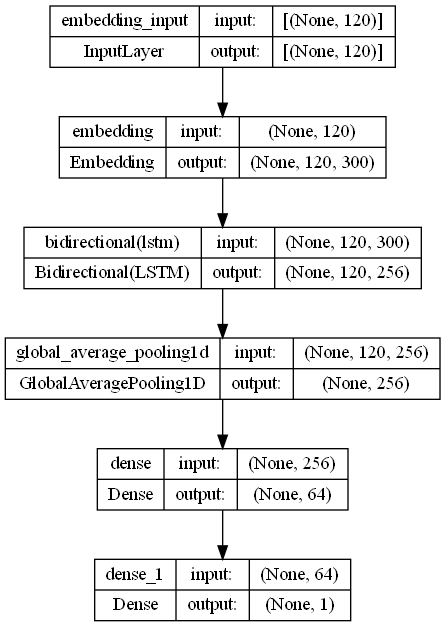

In [27]:
plot_model(model_base, to_file='model_plot2.png', show_shapes=True, show_layer_names=True) 

In [25]:
model_base.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_base = model_base.fit(train_padded, train_label, epochs=15, validation_data=(test_padded, test_label), verbose=1) 

Epoch 1/15
511/511 [==============================] - 133s 253ms/step - loss: 0.4608 - accuracy: 0.7897 - val_loss: 0.3985 - val_accuracy: 0.8275
Epoch 2/15
511/511 [==============================] - 134s 262ms/step - loss: 0.3630 - accuracy: 0.8429 - val_loss: 0.3783 - val_accuracy: 0.8318
Epoch 3/15
511/511 [==============================] - 135s 265ms/step - loss: 0.3364 - accuracy: 0.8558 - val_loss: 0.3822 - val_accuracy: 0.8311
Epoch 4/15
511/511 [==============================] - 136s 265ms/step - loss: 0.3207 - accuracy: 0.8640 - val_loss: 0.3702 - val_accuracy: 0.8396
Epoch 5/15
511/511 [==============================] - 135s 265ms/step - loss: 0.3087 - accuracy: 0.8684 - val_loss: 0.3807 - val_accuracy: 0.8339
Epoch 6/15
511/511 [==============================] - 141s 276ms/step - loss: 0.2932 - accuracy: 0.8763 - val_loss: 0.3888 - val_accuracy: 0.8332
Epoch 7/15
511/511 [==============================] - 141s 276ms/step - loss: 0.2758 - accuracy: 0.8844 - val_loss: 0.3875 -

In [28]:
pred_base = (model_base.predict(test_padded) > 0.5).astype("int32") 
pred_base = pd.DataFrame(pred_base) 

88/88 [==============================] - 8s 87ms/step


In [33]:
print("Test Accuracy:", accuracy_score(pred, test_label)) 
print("Test Precission:", precision_score(pred, test_label, average="macro")) 
print("Test Recall:", recall_score(pred, test_label, average="macro")) 
print("Test F1 Score:", f1_score(pred, test_label, average="macro")) 

Test Accuracy: 0.7478571428571429
Test Precission: 0.5007072135785007
Test Recall: 0.8738835298320828
Test F1 Score: 0.4292538030498312


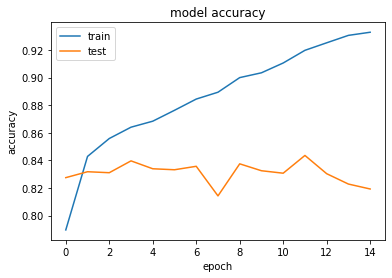

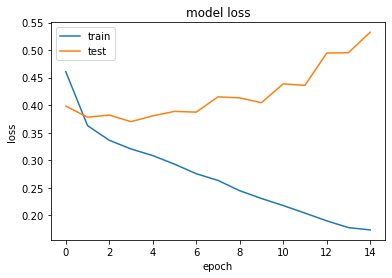

In [32]:
plt.plot(history_base.history['accuracy']) 
plt.plot(history_base.history['val_accuracy']) 

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show() 

## Model Dengan Fasttext     

In [19]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)), 
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

In [20]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 256)         439296    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 755,809
Trainable params: 755,809
Non-trai

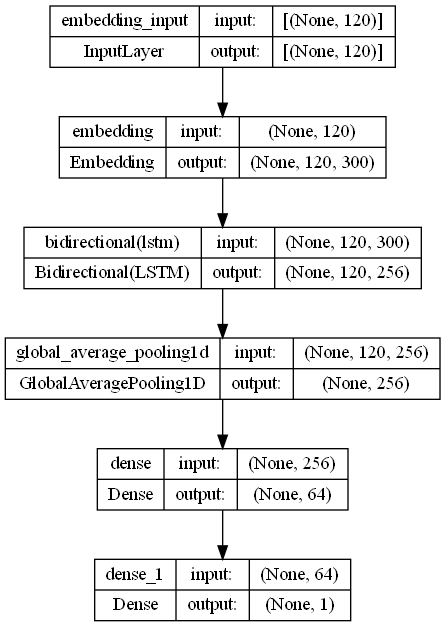

In [22]:
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True) 

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_label, epochs=15, validation_data=(test_padded, test_label), verbose=1) 

Epoch 1/15
511/511 [==============================] - 149s 286ms/step - loss: 0.4687 - accuracy: 0.7799 - val_loss: 0.3915 - val_accuracy: 0.8346
Epoch 2/15
511/511 [==============================] - 137s 268ms/step - loss: 0.3667 - accuracy: 0.8432 - val_loss: 0.3836 - val_accuracy: 0.8404
Epoch 3/15
511/511 [==============================] - 142s 277ms/step - loss: 0.3544 - accuracy: 0.8549 - val_loss: 0.3830 - val_accuracy: 0.8314
Epoch 4/15
511/511 [==============================] - 142s 277ms/step - loss: 0.3380 - accuracy: 0.8590 - val_loss: 0.4150 - val_accuracy: 0.8343
Epoch 5/15
511/511 [==============================] - 141s 275ms/step - loss: 0.3214 - accuracy: 0.8638 - val_loss: 0.3588 - val_accuracy: 0.8443
Epoch 6/15
511/511 [==============================] - 135s 263ms/step - loss: 0.3039 - accuracy: 0.8728 - val_loss: 0.3588 - val_accuracy: 0.8432
Epoch 7/15
511/511 [==============================] - 135s 264ms/step - loss: 0.2864 - accuracy: 0.8815 - val_loss: 0.3745 -

In [23]:
pred = (model.predict(test_padded) > 0.5).astype("int32") 
pred = pd.DataFrame(pred) 

88/88 [==============================] - 6s 63ms/step


In [24]:
print("Test Accuracy:", accuracy_score(pred, test_label)) 
print("Test Precission:", precision_score(pred, test_label, average="macro")) 
print("Test Recall:", recall_score(pred, test_label, average="macro")) 
print("Test F1 Score:", f1_score(pred, test_label, average="macro")) 

Test Accuracy: 0.8314285714285714
Test Precission: 0.7865539540098301
Test Recall: 0.776024460372647
Test F1 Score: 0.780962280962281


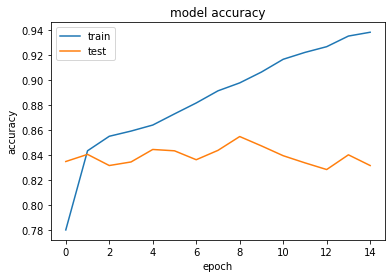

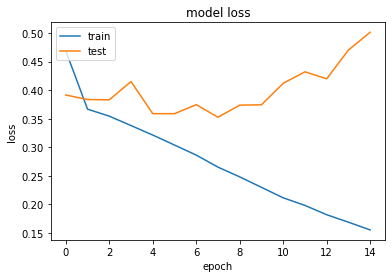

In [25]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show() 